In [2]:
import numpy as np
from collections import Counter
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from numpy.polynomial import Polynomial

In [3]:
class Num(float):
    counts = Counter(mul=0, add=0)
    def __add__(self, other):
        self.counts["add"] += 1
        return Num(super(Num, self).__add__(other))
    def __radd__(self, other):
        self.counts["add"] += 1
        return Num(super(Num, self).__radd__(other))
    def __mul__(self, other):
        self.counts["mul"] += 1
        return Num(super(Num, self).__mul__(other))
    def __rmul__(self, other):
        self.counts["mul"] += 1
        return Num(super(Num, self).__rmul__(other))
    def __sub__(self, other):
        self.counts["add"] += 1
        return Num(super(Num, self).__sub__(other))
    def __rsub__(self, other):
        self.counts["add"] += 1
        return Num(super(Num, self).__rsub__(other))
    def reset_counter(self):
        self.counts["mul"] = 0
        self.counts["add"] = 0


n = Num(9)
m = Num(18)
m += Num(18)
n += m

j = Num(90)
j += 1
j += 1
j += 1
j += 1
a = 5
a += Num(9)
a = 5
a *= Num(9)
a = 5
a -= Num(9)
print(n, m.counts)

j.reset_counter()

45.0 Counter({'add': 8, 'mul': 1})


In [8]:
class MatrixMultiplier:

    def __init__(self, A, B):
        self.A = A
        self.B = B
        self.result = np.zeros((1, 1), dtype=A.dtype)
        filename = 'factorizations_r.npz'
        with open(filename, 'rb') as f:
            self.factorizations = dict(np.load(f, allow_pickle=True))

    def is_power_of_two(self, n):
        if n == 1 or n == 0:
            return 0
        return (n & (n - 1)) == 0

    def matrix_partition_sq2(self, A):
        n = A.shape[0] // 2
        m = A.shape[1] // 2
        A11 = A[:n, :m]
        A12 = A[:n, m:]
        A21 = A[n:, :m]
        A22 = A[n:, m:]
        return A11, A12, A21, A22

    def matrix_repartition_sq2(self, A11, A12, A21, A22):
        C = np.block([[A11, A12],
                      [A21, A22]])
        return C

    def iterative_wrap(self, A, B):
        C = np.zeros((A.shape[0], B.shape[1]))
        for i in range(A.shape[0]):
            for j in range(B.shape[1]):
                s = Num(0)
                for k in range(B.shape[0]):
                    s += A[i, k] * B[k, j]
                C[i, j] = s
        self.result = C
        return C

    def binet_wrap(self, A, B):
        C = np.zeros((1, 1), dtype=A.dtype)

        if 1 or (A.shape[0] == A.shape[1] and A.shape[1] == B.shape[0] and B.shape[0] == B.shape[1]):
            if A.shape[0] == 1 or A.shape[1] == 1:
                return np.array([[Num(A[0, 0] * B[0, 0])]], dtype=Num)
            else:
                A11, A12, A21, A22 = self.matrix_partition_sq2(A)
                B11, B12, B21, B22 = self.matrix_partition_sq2(B)
                C = self.matrix_repartition_sq2(self.binet_wrap(A11, B11) + self.binet_wrap(A12, B21),
                                                self.binet_wrap(A11, B12) + self.binet_wrap(A12, B22),
                                                self.binet_wrap(A21, B11) + self.binet_wrap(A22, B21),
                                                self.binet_wrap(A21, B12) + self.binet_wrap(A22, B22))

        return C

    def strassen_wrap(self, A, B):
        C = np.zeros((1, 1), dtype=A.dtype)

        if A.shape[0] == A.shape[1] and A.shape[1] == B.shape[0] and B.shape[0] == B.shape[1]:
            if A.shape[0] == 1:
                return np.array([[Num(A[0, 0] * B[0, 0])]], dtype=Num)
            elif B.shape[0] > 1 and (B.shape[0] & (B.shape[0] - 1)) == 0:
                A11, A12, A21, A22 = self.matrix_partition_sq2(A)
                B11, B12, B21, B22 = self.matrix_partition_sq2(B)
                P1 = self.strassen_wrap(A11 + A22, B11 + B22)
                P2 = self.strassen_wrap(A21 + A22, B11)
                P3 = self.strassen_wrap(A11, B12 - B22)
                P4 = self.strassen_wrap(A22, B21 - B11)
                P5 = self.strassen_wrap(A11 + A12, B22)
                P6 = self.strassen_wrap(A21 - A11, B11 + B12)
                P7 = self.strassen_wrap(A12 - A22, B21 + B22)

                C = self.matrix_repartition_sq2(P1 + P4 - P5 + P7, P3 + P5,
                                                P2 + P4, P1 - P2 + P3 + P6)

        return C

    def algorithm_from_factors(self, factors: np.ndarray, n, m, k):
        factors = [factors[0].copy(), factors[1].copy(), factors[2].copy()]
        rank = factors[0].shape[-1]
        factors[0] = factors[0].reshape(n, m, rank)
        factors[1] = factors[1].reshape(m, k, rank)
        factors[2] = factors[2].reshape(k, n, rank)
        factors[2] = factors[2].transpose(1, 0, 2)

        def f(a, b):
            n = a.shape[0]
            m = a.shape[1]
            l = b.shape[1]

            result = np.array([[0 for _ in range(l)] for _ in range(n)], dtype=Num)
            for alpha in range(rank):
                left = Num()
                for i in range(n):
                    for j in range(m):
                        if factors[0][i, j, alpha] != 0:
                            curr = factors[0][i, j, alpha] * a[i][j]
                            left += curr
                right = Num()
                for j in range(m):
                    for k in range(l):
                        if factors[1][j, k, alpha] != 0:
                            curr = factors[1][j, k, alpha] * b[j][k]
                            right += curr
                matrix_product = left * right
                for i in range(n):
                    for k in range(l):
                        if factors[2][i, k, alpha] != 0:
                            curr = factors[2][i, k, alpha] * matrix_product
                            result[i, k] += curr
            return result

        return f

    def iterative(self):
        self.result = self.iterative_wrap(self.A, self.B)
        return self.result

    def strassen(self):
        self.result = self.strassen_wrap(self.A, self.B)
        return self.result

    def binet(self):
        self.result = self.binet_wrap(self.A, self.B)
        return self.result

    def alphatensor(self, A, B):
        assert A.shape[1] == B.shape[0]
        n = A.shape[0]
        m = A.shape[1]
        k = B.shape[1]
        factors = self.factorizations[str(n) + ',' + str(m) + ',' + str(k)]
        matrix_mul_algorithm = self.algorithm_from_factors(factors, n, m, k)
        return matrix_mul_algorithm(A, B)

    def alpha_strassen_wrap(self, A, B):
        C = np.zeros((1, 1), dtype=A.dtype)

        if (str(A.shape[0]) + ',' + str(A.shape[1]) + ',' + str(B.shape[1])) in self.factorizations:
            return self.alphatensor(A, B)
        elif A.shape[0] == 1:
            return np.array([[Num(A[0, 0] * B[0, 0])]], dtype=Num)
        else:
            A11, A12, A21, A22 = self.matrix_partition_sq2(A)
            B11, B12, B21, B22 = self.matrix_partition_sq2(B)
            P1 = self.alpha_strassen_wrap(A11 + A22, B11 + B22)
            P2 = self.alpha_strassen_wrap(A21 + A22, B11)
            P3 = self.alpha_strassen_wrap(A11, B12 - B22)
            P4 = self.alpha_strassen_wrap(A22, B21 - B11)
            P5 = self.alpha_strassen_wrap(A11 + A12, B22)
            P6 = self.alpha_strassen_wrap(A21 - A11, B11 + B12)
            P7 = self.alpha_strassen_wrap(A12 - A22, B21 + B22)

            C = self.matrix_repartition_sq2(P1 + P4 - P5 + P7, P3 + P5,
                                            P2 + P4, P1 - P2 + P3 + P6)

        return C
    def alpha_binet_wrap(self, A, B):
        C = np.zeros((1, 1), dtype=A.dtype)
        if (str(A.shape[0]) + ',' + str(A.shape[1]) + ',' + str(B.shape[1])) in self.factorizations:
            return self.alphatensor(A, B)
        elif A.shape[0] == 1:
            return np.array([[Num(A[0, 0] * B[0, 0])]], dtype=Num)
        else:
            A11, A12, A21, A22 = self.matrix_partition_sq2(A)
            B11, B12, B21, B22 = self.matrix_partition_sq2(B)
            C = self.matrix_repartition_sq2(self.alpha_binet_wrap(A11, B11) + self.alpha_binet_wrap(A12, B21),
                                            self.alpha_binet_wrap(A11, B12) + self.alpha_binet_wrap(A12, B22),
                                            self.alpha_binet_wrap(A21, B11) + self.alpha_binet_wrap(A22, B21),
                                            self.alpha_binet_wrap(A21, B12) + self.alpha_binet_wrap(A22, B22))

        return C
    def alpha_strassen(self):
        self.result = np.array(self.alpha_strassen_wrap(self.A, self.B), dtype=Num)
        return self.result

    def alpha_binet(self):
        self.result = np.array(self.alpha_binet_wrap(self.A, self.B), dtype=Num)
        return self.result

    def reset_counter(self):
        Num().reset_counter()

    def check(self):
        return np.allclose(np.array(self.result, dtype=float), np.array(self.A @ self.B, dtype=float), rtol=1e-05,
                           atol=1e-08, equal_nan=False)

    def get_current_flops(self):
        return Num().counts



In [9]:
def create_M_2(n):
    n = 2 ** n
    return np.array([[Num((random.uniform(0.00000001, 1))) for i in range(n)] for j in range(n)], dtype=Num)
def create_matrices_for_alphabinet(n):
    n = 2 ** n
    A = np.array([[Num((random.uniform(0.00000001, 1))) for i in range(4*n)] for j in range(4*n)], dtype=Num)
    B = np.array([[Num((random.uniform(0.00000001, 1))) for i in range(5*n)] for j in range(4*n)], dtype=Num)
    return A, B

In [19]:
A = create_M_2(4)
B = create_M_2(4)
A = np.array([[Num((random.uniform(0.00000001, 1))) for i in range(3)] for j in range(3)], dtype=Num)
B = np.array([[Num((random.uniform(0.00000001, 1))) for i in range(3)] for j in range(3)], dtype=Num)

M = MatrixMultiplier(A, B)
# M.reset_counter()
# M.strassen()
# print(M.get_current_flops())
M.reset_counter()
M.binet()
print(M.get_current_flops())

IndexError: index 0 is out of bounds for axis 1 with size 0

In [15]:
def test_functions(bound):
    df = pd.DataFrame()
    MM = MatrixMultiplier(create_M_2(1), create_M_2(1))
    for n in range(2, bound):
        MM.A, MM.B = create_M_2(n), create_M_2(n)
        methods = {"Iterative":MM.iterative, "Binet":MM.binet, "Strassen":MM.strassen, "AlphaStrassen": MM.alpha_strassen, "AlphaBinet":MM.alpha_binet}
        for method_name, method in methods.items():
            print(n, method_name[0], end=" ")
            if method_name == "AlphaBinet":
                MM.A, MM.B = create_matrices_for_alphabinet(n)
            method()
            df.at[n, method_name] = MM.check()
    return df

In [16]:
# test_functions(5)

In [17]:
def stat_functions(bound):
    df_times = pd.DataFrame()
    df_add = pd.DataFrame()
    df_mul = pd.DataFrame()
    df_test = pd.DataFrame()
    MM = MatrixMultiplier(create_M_2(1), create_M_2(1))
    for n in range(2, bound):
        MM.A, MM.B = create_M_2(n), create_M_2(n)
        methods = {"Iterative":MM.iterative, "Binet":MM.binet, "Strassen":MM.strassen, "AlphaStrassen":MM.alpha_strassen, "AlphaBinet":MM.alpha_binet, "IterativeForBinet":MM.iterative}
        for method_name, method in methods.items():
            MM.reset_counter()
            print(n, method_name[0], end=" ")
            if (method_name == "AlphaBinet" or method_name == "IterativeForBinet") and n > 5 : continue 
            if method_name == "AlphaBinet":
                MM.A, MM.B = create_matrices_for_alphabinet(n)
            start_time = time()
            method()
            df_times.at[n, method_name] = time() - start_time
            df_add.at[n, method_name] = MM.get_current_flops()["add"]
            df_mul.at[n, method_name] = MM.get_current_flops()["mul"]
            df_test.at[n, method_name] = MM.check()
    return df_times, df_add, df_mul, df_test

In [18]:
df_s = stat_functions(10)

2 I 2 B 2 S 2 A 2 A 2 I 3 I 3 B 3 S 3 A 3 A 3 I 4 I 4 B 4 S 4 A 4 A 4 I 5 I 5 B 5 S 5 A 5 A 5 I 6 I 6 B 6 S 6 A 6 A 6 I 7 I 7 B 7 S 7 A 7 A 7 I 8 I 8 B 8 S 8 A 8 A 8 I 9 I 9 B 9 S 9 A 9 A 9 I 

In [32]:
def plot_stats(dfs):
    titles = ["Methods' times comparison", "Methods' addition counts comparison", "Methods' multiplication counts comparison"]
    y_labels = ["Time [s]", "Addition count", "Multiplication count"]
    fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8, 18*2))
    i = 0
    for df, title, y_label in zip(dfs, titles, y_labels):

        df_alpha = df[['AlphaBinet', 'IterativeForBinet']]
        df.pop("AlphaBinet")
        df.pop("IterativeForBinet")
        # Polynomial interpolation and plotting
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")
        df_2 = [df, df_alpha]
        for j in range(2):
            ax = axes[i + j]
            for method in df_2[j].columns:
                x = df_2[j].index
                y = df_2[j][method]
                
                
                y=y.dropna(how='all')
                x=x.dropna(how='all')[:len(y)]
                # print(x)
                # print(y)
                

                # Polynomial interpolation
                coefficients = np.polyfit(x, y, len(x) - 1)
                polynomial = np.poly1d(coefficients)

                # Generate interpolated x values
                x_interp = np.linspace(min(x), max(x), 100)

                # Plot the interpolated curve
                ax.plot(x_interp, polynomial(x_interp), label=method)
                ax.scatter(x, y)

            # Set labels and title
            s = ""
            if j == 1:
                s = " (Matrices of sizes 4*2^x $\\times$ 4*2^x and 4*2^x $\\times$ 5*2^x)"
            else:
                s = " (Matrices of sizes 2^x $\\times$ 2^x and 2^x $\\times$ 2^x)"
            ax.set_xlabel('Size od matrices ($\log_2$ scale)' + s)
            ax.set_ylabel(y_label)
            ax.set_title(title)

            # Show legend
            ax.legend()
        i += 2

    plt.show()


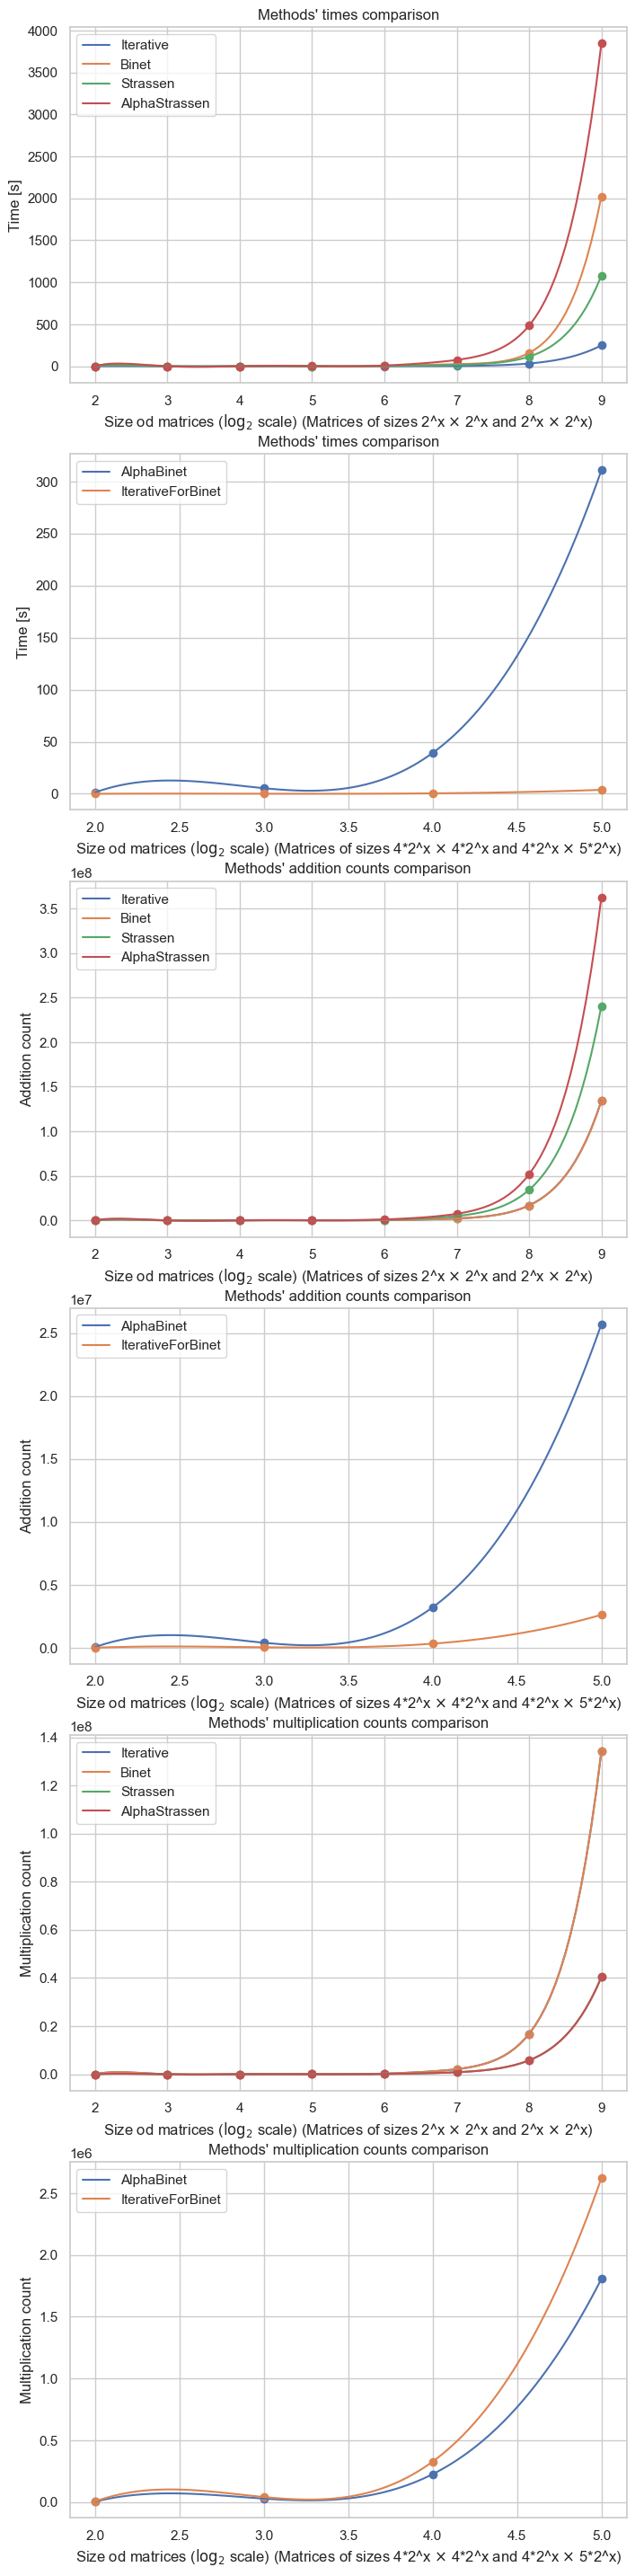

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

   Iterative  Binet  Strassen  AlphaStrassen AlphaBinet IterativeForBinet
2       True   True      True           True       True              True
3       True   True      True           True       True              True
4       True   True      True           True       True              True
5       True   True      True           True       True              True
6       True   True      True           True        NaN               NaN
7       True   True      True           True        NaN               NaN
8       True   True      True           True        NaN               NaN
9       True   True      True           True        NaN               NaN


In [42]:
# dfs = [df.copy() for df in df_s]
dfs = [pd.read_csv("csv/df_"+str(i)+".csv", index_col=0) for i in range(4)]

plot_stats(dfs[:3])
print(dfs[3])

In [ ]:
# for i, df in enumerate(df_s):
#     df.to_csv("csv/df_"+str(i)+".csv")

In [40]:
MMM = MatrixMultiplier(np.array([[1, 2],[3, 4]]), np.array([[1, 2], [3, 4]]))
MMM.binet()
MMM.result

array([[7.0, 10.0],
       [15.0, 22.0]], dtype=object)